In [349]:
import pandas as pd
import numpy
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4.8
import math
from sklearn.preprocessing import MinMaxScaler
#15, 6
import matplotlib.pyplot as plt
import time
import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy
from sklearn import preprocessing

In [350]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [34]:
#filedata= 'C:/Users/C00310965/Documents/livros/source/train_test_lago_sul_20160907_20160930.csv'
#filedata= 'C:/Users/C00310965/Desktop/caloba/DFSQS68lagosul_cell_2017.csv'
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%')
#dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M')
#data = pd.read_csv('C:/Users/C00310965/Documents/livros/source/train_test_lago_sul_20160907_20160930.csv',sep=',', parse_dates=['date'],index_col='date',date_parser=dateparse)
#data = pd.read_csv('C:/Users/C00310965/Documents/livros/source/train_test_lago_sul_20160907_20160930.csv',sep=',', parse_dates=['date'],date_parser=dateparse)
#dataframe = pd.read_csv(filedata, engine='python', sep=';')

In [ ]:
###testes

# Import data

In [435]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
#dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M')
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
data = pd.read_csv('D:/Development/livros/source/hs_users_3.csv',sep=';', parse_dates=['DATE'],index_col='DATE',date_parser=dateparse)
print data.head()
print '\n Data Types:'
print data.dtypes

                     users
DATE                      
2017-01-01 11:00:00   43.0
2017-01-01 12:00:00   47.0
2017-01-01 13:00:00   43.5
2017-01-01 14:00:00   47.0
2017-01-01 15:00:00   47.0

 Data Types:
users    float64
dtype: object


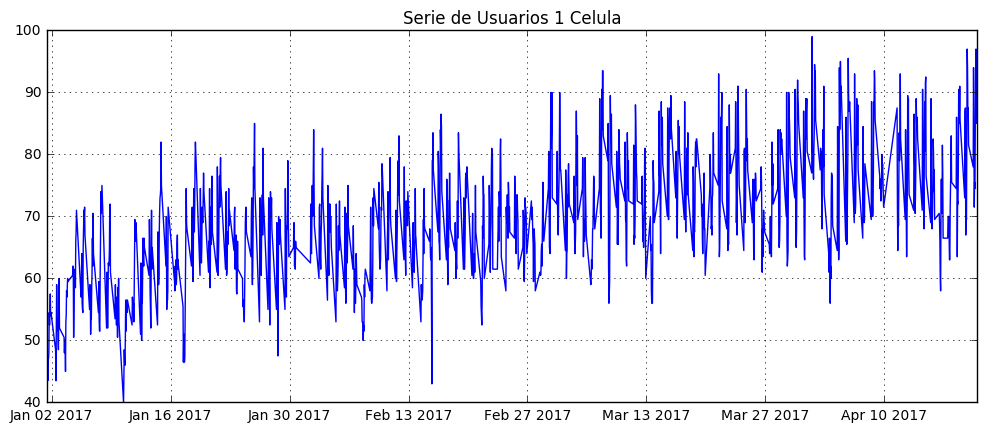

In [11]:
###plot
ds = data.groupby(pd.TimeGrouper(freq='h')).sum().dropna()
plt.title('Serie de Usuarios 1 Celula')
plt.grid()
plt.plot(ds.users)
plt.show()

# Correlação Cruzada

In [400]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

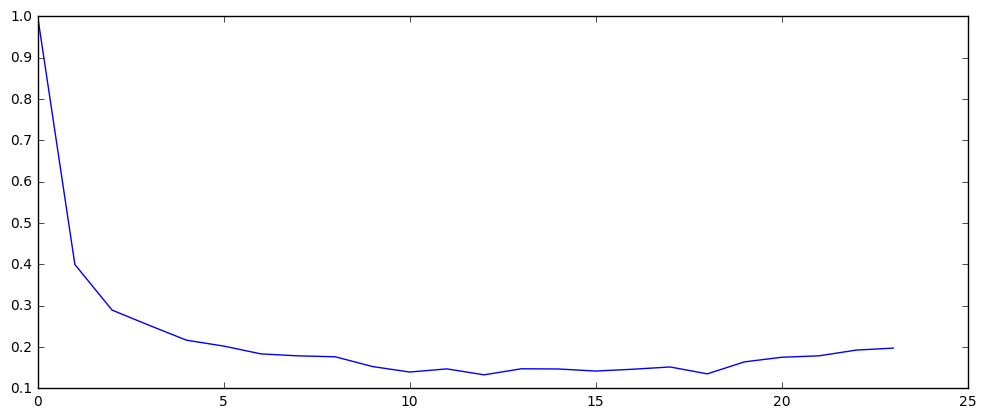

In [404]:
xcov_daily = [crosscorr(data.cell_downlink_avg_thp, data.cell_downlink_avg_thp, lag=i) for i in range(24)]
plt.plot(xcov_daily)

# Drop Null Values from the dataset

In [5]:
data.dropna(inplace=True)

In [18]:
len(data['2017-01-01 00:00:00':'2017-02-01 00:00:00'])

724

# Separar Dataset

In [49]:
train_set = data['2017-01-01 11:00:00':'2017-03-14 22:00:00']
test_set = data['2017-03-15 11:00:00':'2017-04-20 22:00:00']
data_total = data['2017-01-01 00:00:00':'2017-04-20 22:00:00'] 
print(train_set.shape)
print(test_set.shape)
print(data_total.shape)
print(train_set.shape[0]+test_set.shape[0])

(851, 1)
(427, 1)
(1278, 1)
1278


# Teste Homoscedasticity

In [22]:
train_set.downlink_traffic_volume.shape

(3510L,)

In [86]:
#import scipy
#scipy.stats.bartlett()

# Teste de raízes unitárias 

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12*7)
    rolstd = pd.rolling_std(timeseries, window=12*7)

    #Plot rolling statistics:
    orig = timeseries.plot(color='blue',label='Original',use_index=False)
    mean = rolmean.plot(color='red', label='Rolling Mean',use_index=False)
    std = rolstd.plot(color='black', label = 'Rolling Std',use_index=False)    
    #orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=84,center=False).mean()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=84,center=False).std()


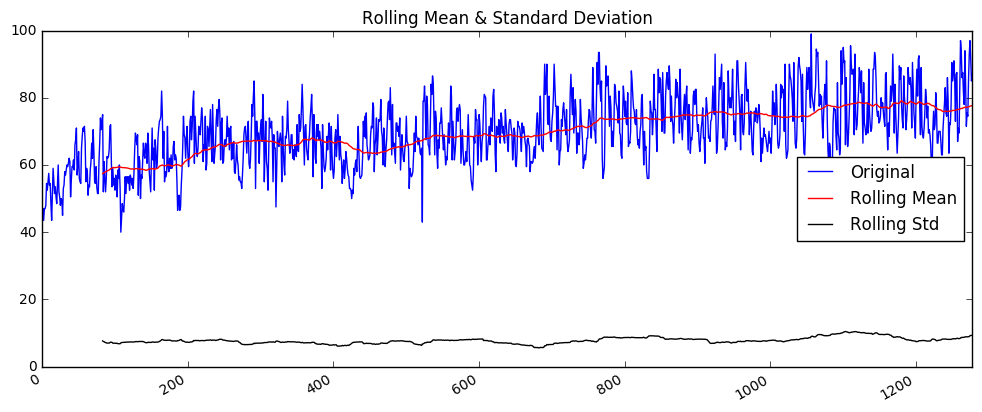

Results of Dickey-Fuller Test:
Test Statistic                   -3.030858
p-value                           0.032111
#Lags Used                       23.000000
Number of Observations Used    1254.000000
Critical Value (5%)              -2.863848
Critical Value (1%)              -3.435575
Critical Value (10%)             -2.567999
dtype: float64


In [25]:
test_stationarity(data.users)

# Verificar Tendência

In [56]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
print(train_set.index.shape, train_set['users'].shape)
linearReg.fit(train_set.index[:, numpy.newaxis], train_set['users'])
linearReg.predict(train_set.index[:, numpy.newaxis])
train_set_without_tendency = linearReg.predict(train_set.index[:, numpy.newaxis])
plt.plot(train_set['users'])
plt.plot(train_set_without_tendency)
plt.show()

((851L,), (851L,))


TypeError: Cannot cast array data from dtype('<M8[ns]') to dtype('float64') according to the rule 'safe'

# FFT para detectar sazonalidade

In [34]:
ds = data.groupby(pd.TimeGrouper(freq='h')).sum().dropna()
#print(rolmean[~numpy.isnan(rolmean)].shape)
#print(ds.downlink_traffic_volume.values)

In [329]:
import scipy
n_fft = 256
fs = 1
freqsig = scipy.fft(rolmean[~numpy.isnan(rolmean)],n=n_fft)
freqaxis = numpy.arange(0,fs,fs/float(n_fft))

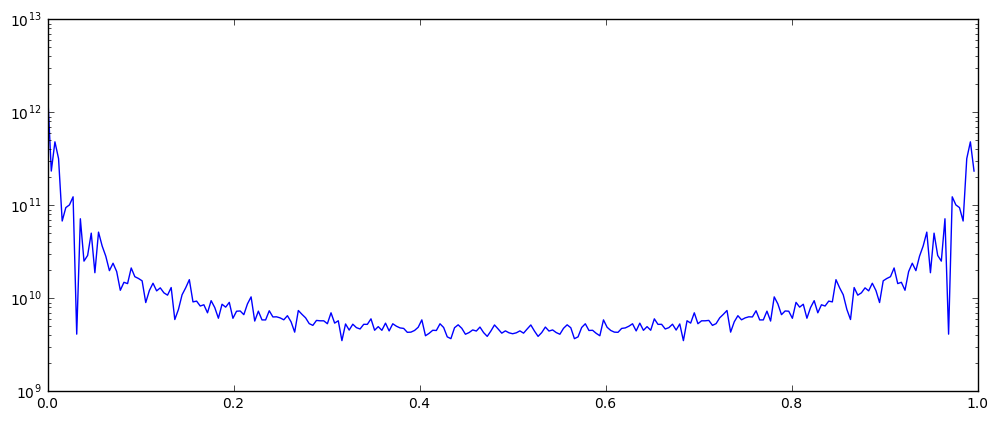

In [369]:
plt.semilogy(freqaxis,numpy.abs(freqsig))

In [52]:
from scipy import signal
f, Pxx_den = signal.welch(residual.values, 1, nperseg=256)

In [53]:
#itemindex = Pxx_den.where(array==max(Pxx_den))
#itemindex = Pxx_den.argmax()
Pxx_den.argsort()[-10:][::-1]

array([22, 21,  3,  4,  6,  7, 23, 64,  5, 20], dtype=int64)

In [54]:
#itemindex = Pxx_den.where(array==max(Pxx_den))
#itemindex = Pxx_den.argmax()
#Pxx_den.argsort()[-3:][::-1]
print(f[43])
print(1/f[43])

0.16796875
5.95348837209


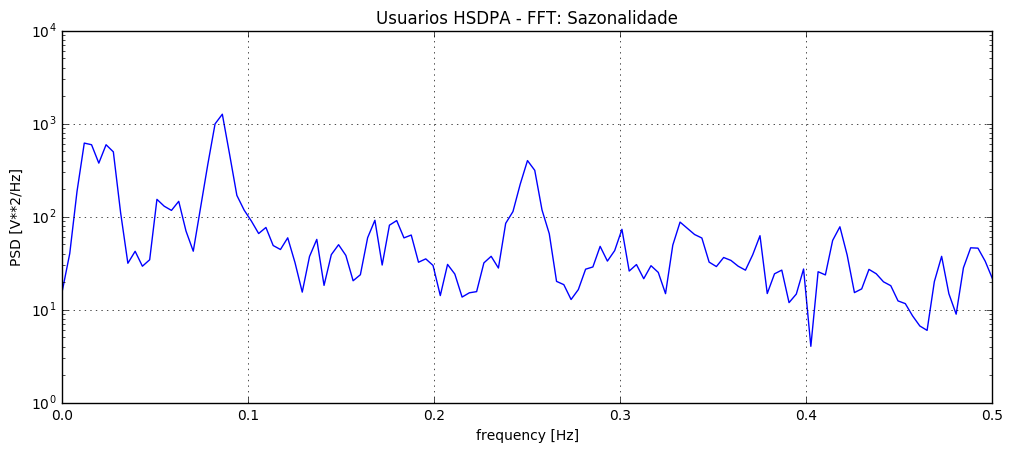

In [55]:
#plt.semilogy(f, numpy.sqrt(Pxx_den))
plt.grid()
plt.semilogy(f, Pxx_den)
#plt.plot(f, numpy.sqrt(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Usuarios HSDPA - FFT: Sazonalidade')

In [73]:
#test_stationarity(numpy.log(data.downlink_traffic_volume))
#testeaaa = data['downlink_traffic_volume']
#data.set_index('date', inplace = True)
print(data.index) 

DatetimeIndex(['2017-01-01 11:00:00', '2017-01-01 12:00:00',
               '2017-01-01 13:00:00', '2017-01-01 14:00:00',
               '2017-01-01 15:00:00', '2017-01-01 16:00:00',
               '2017-01-01 17:00:00', '2017-01-01 18:00:00',
               '2017-01-01 19:00:00', '2017-01-01 20:00:00',
               ...
               '2017-04-20 13:00:00', '2017-04-20 14:00:00',
               '2017-04-20 15:00:00', '2017-04-20 16:00:00',
               '2017-04-20 17:00:00', '2017-04-20 18:00:00',
               '2017-04-20 19:00:00', '2017-04-20 20:00:00',
               '2017-04-20 21:00:00', '2017-04-20 22:00:00'],
              dtype='datetime64[ns]', name=u'DATE', length=1278, freq=None)


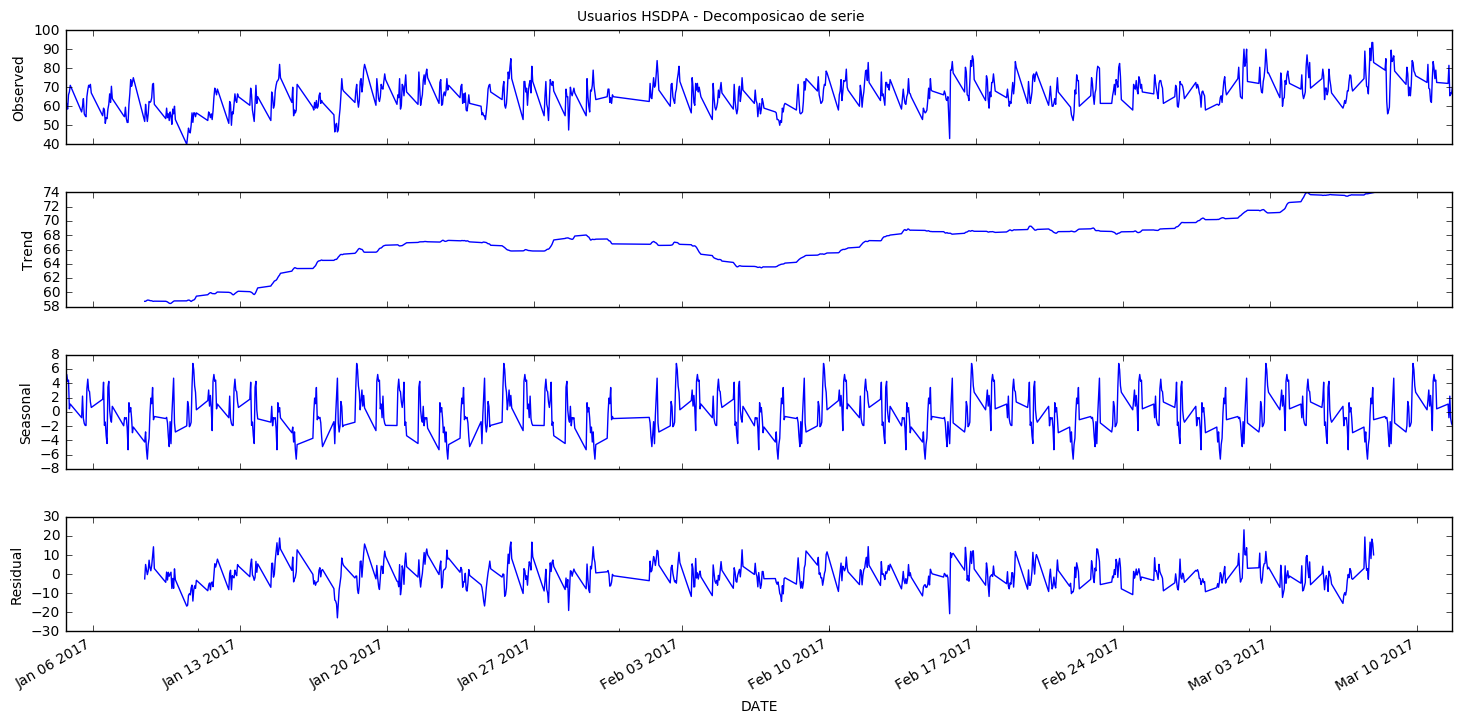

In [428]:
###24h*60min/15min*7days
#decomposition = sm.tsa.seasonal_decompose(data)
decomposition = sm.tsa.seasonal_decompose(train_set.users,freq=12*7)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
fig.suptitle('Usuarios HSDPA - Decomposicao de serie')

In [55]:
#decomposition = sm.tsa.seasonal_decompose(data.cell_downlink_avg_thp,freq=24*30)


#fig = plt.figure()  
#fig = decomposition.plot()  
#fig.set_size_inches(15, 8)
#fig.suptitle('Usuarios HSDPA Lago Sul, DF (1 celula)')

In [51]:
#plt.plot(decomposition.trend)
residuals = decomposition.resid
residual = residuals.dropna(axis=0, how='any')
print(residual)

DATE
2017-01-04 17:00:00    -2.480890
2017-01-04 18:00:00    -1.224045
2017-01-04 19:00:00    -2.744580
2017-01-04 20:00:00     3.335479
2017-01-04 21:00:00     8.476848
2017-01-04 22:00:00    11.013753
2017-01-05 11:00:00    -1.130295
2017-01-05 12:00:00     0.653039
2017-01-05 13:00:00     6.522682
2017-01-05 14:00:00    -0.232080
2017-01-05 15:00:00    -1.441306
2017-01-05 16:00:00    -2.124342
2017-01-05 17:00:00     2.569772
2017-01-05 18:00:00     4.373343
2017-01-05 19:00:00     7.890208
2017-01-05 20:00:00     7.170301
2017-01-05 21:00:00     9.818780
2017-01-05 22:00:00     6.488422
2017-01-06 11:00:00    -5.236445
2017-01-06 12:00:00    -3.810850
2017-01-06 13:00:00     0.619705
2017-01-06 14:00:00    -6.070440
2017-01-06 15:00:00    -1.712636
2017-01-06 16:00:00    -1.193456
2017-01-06 17:00:00    -3.715281
2017-01-06 18:00:00    -2.145506
2017-01-06 19:00:00     6.361108
2017-01-06 20:00:00     3.467258
2017-01-06 21:00:00    11.450724
2017-01-06 22:00:00     3.710645
     

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=84,center=False).mean()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=84,center=False).std()


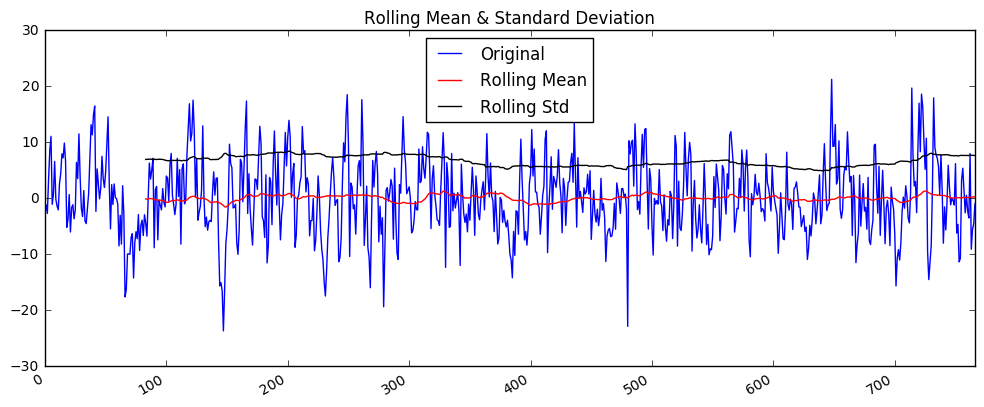

Results of Dickey-Fuller Test:
Test Statistic                -7.620371e+00
p-value                        2.136393e-11
#Lags Used                     1.700000e+01
Number of Observations Used    7.490000e+02
Critical Value (5%)           -2.865407e+00
Critical Value (1%)           -3.439111e+00
Critical Value (10%)          -2.568829e+00
dtype: float64


In [78]:
test_stationarity(residual)

In [ ]:
#preprocessing.scale(X_train)

# Trabalho no dataset

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

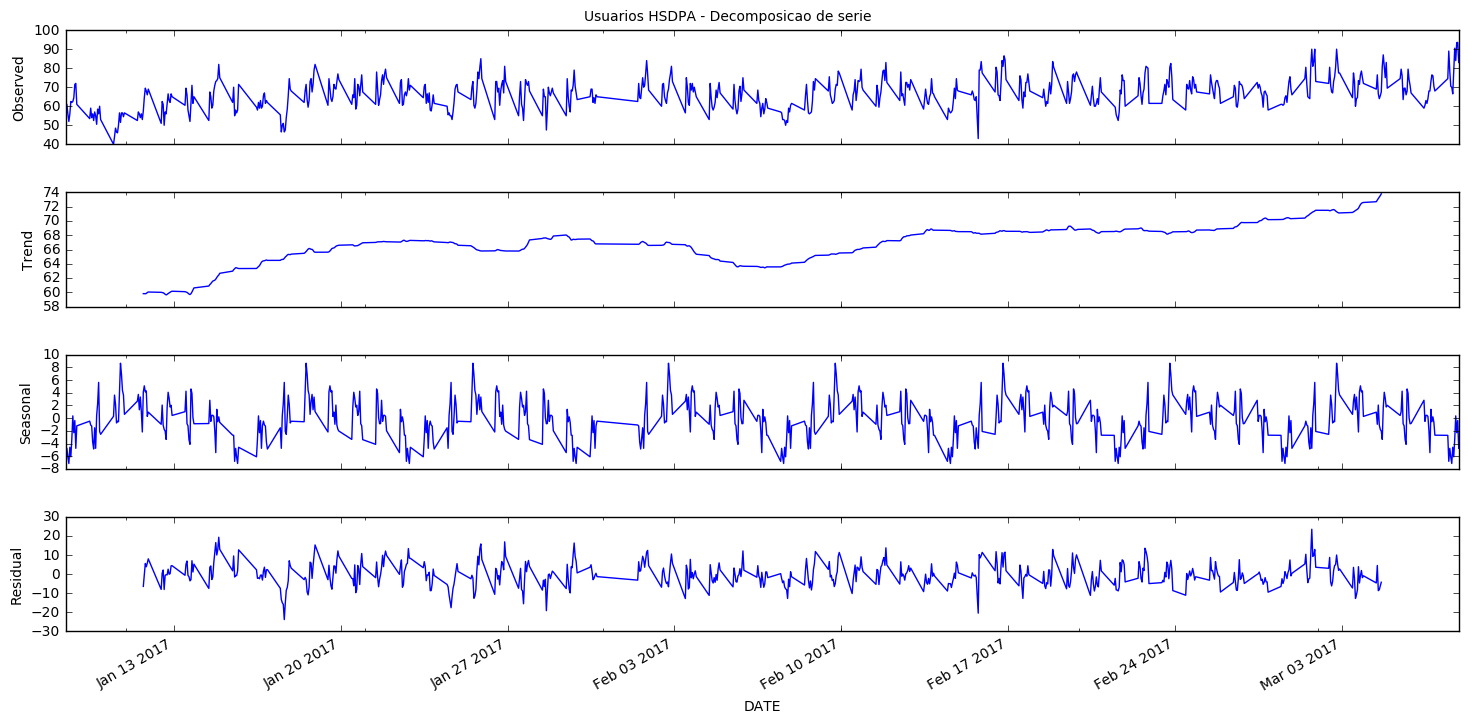

In [430]:
#train_set.set_index('date', inplace = True)
s = sm.tsa.seasonal_decompose(train_set.users,freq=12*7)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()
fig = plt.figure()  
fig = s.plot()  
fig.set_size_inches(15, 8)
fig.suptitle('Usuarios HSDPA - Decomposicao de serie')

# Adiciona Outliers

In [409]:
test_set.users

DATE
2017-03-18 17:00:00     70.0
2017-03-18 18:00:00     80.5
2017-03-18 19:00:00     82.0
2017-03-18 20:00:00     78.0
2017-03-18 21:00:00     82.5
2017-03-18 22:00:00     82.5
2017-03-19 11:00:00     73.5
2017-03-19 12:00:00     70.0
2017-03-19 13:00:00     72.0
2017-03-19 14:00:00     66.5
2017-03-19 15:00:00     64.0
2017-03-19 16:00:00     67.5
2017-03-19 17:00:00     71.0
2017-03-19 18:00:00     73.0
2017-03-19 19:00:00     77.0
2017-03-19 20:00:00     68.0
2017-03-19 21:00:00     68.0
2017-03-19 22:00:00     60.5
2017-03-20 11:00:00     74.5
2017-03-20 12:00:00     80.0
2017-03-20 13:00:00     76.5
2017-03-20 14:00:00     74.0
2017-03-20 15:00:00     68.0
2017-03-20 16:00:00     68.5
2017-03-20 17:00:00     67.0
2017-03-20 18:00:00     73.0
2017-03-20 19:00:00     73.5
2017-03-20 20:00:00     77.0
2017-03-20 21:00:00     83.5
2017-03-20 22:00:00     77.0
                       ...  
2017-04-15 11:00:00     69.0
2017-04-15 12:00:00     89.0
2017-04-15 13:00:00     71.5
2017-04-1

In [425]:
test_set.users['2017-04-11 17:00:00'] = 360

In [433]:
#test_set.set_index('date', inplace = True)
#F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(test_set.users, freq = 12*7)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\si

,users,ResidualSeries,SeasonalSeries,TrendSeries
DATE,,,,


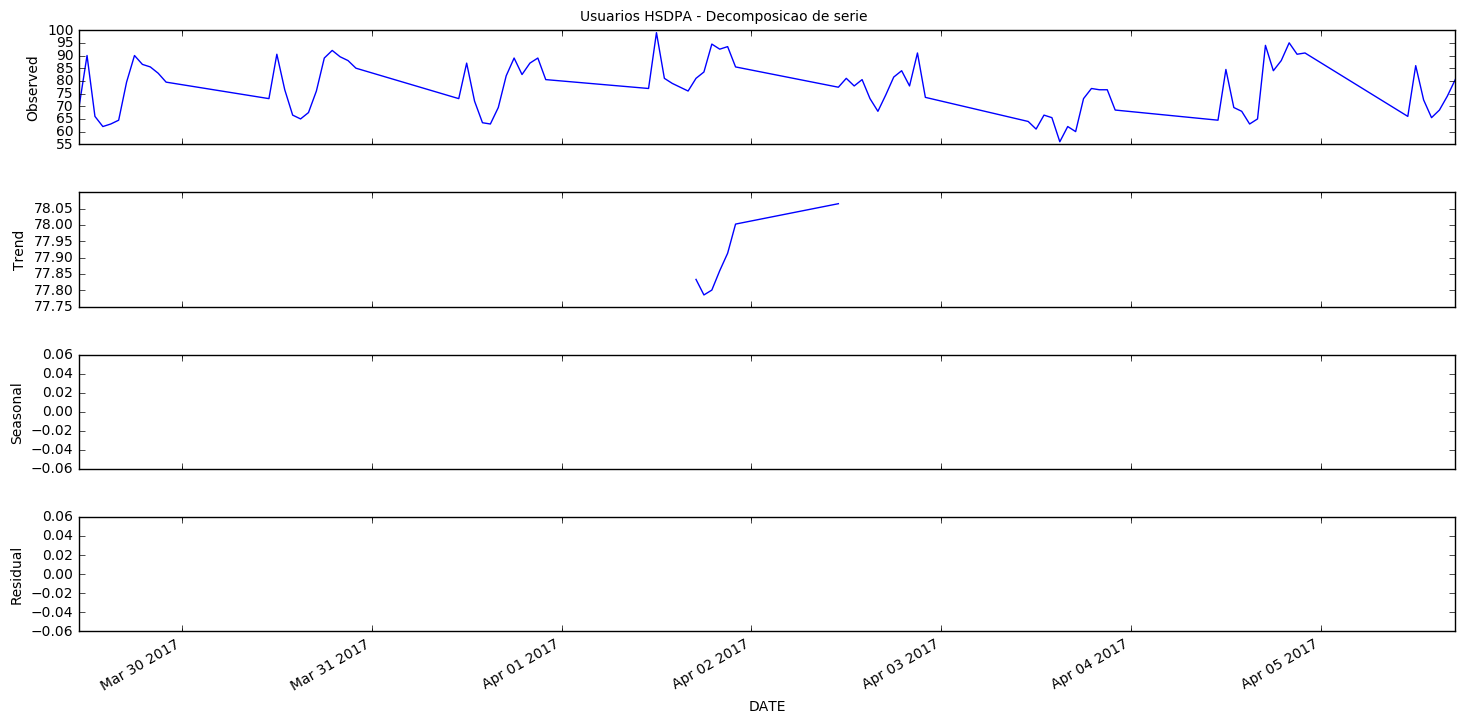

In [434]:
fig = plt.figure()  
fig = sTest.plot()  
fig.set_size_inches(15, 8)
fig.suptitle('Usuarios HSDPA - Decomposicao de serie')

# MLP

In [91]:
#dataset = residual.values
#dataset = dataset.astype('float32')
#dataset = numpy.expand_dims(dataset, axis=1) 
# split into train and test sets
#train_size = int(len(dataset) * 0.674682)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

In [92]:
#print(trainPredictPlot[6000],testPredictPlot[6000])

In [412]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return numpy.array(dataX), numpy.array(dataY)

In [413]:
look_back=4

In [415]:
test_set['ResidualSeries'].std()

6.0304092984890865

In [259]:
train_values.std()

0.99934789689837344

In [416]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values, look_back = look_back)
testx, testy = create_dataset(test_values, look_back = look_back)
print(y[:10], '\n',train_values[:30])
print(x.shape, y.shape)

(array([ 1.25885652,  1.63964051, -0.18315514,  0.08451939,  0.96554027,
       -0.04833509, -0.22983736, -0.33235956,  0.3722169 ,  0.64292913]), '\n', array([-0.3858766 , -0.19722681, -0.42545598,  0.48714799,  1.25885652,
        1.63964051, -0.18315514,  0.08451939,  0.96554027, -0.04833509,
       -0.22983736, -0.33235956,  0.3722169 ,  0.64292913,  1.17080307,
        1.06274651,  1.46027753,  0.96039803, -0.79947961, -0.58550081,
        0.07951613, -0.92466044, -0.27056332, -0.19263552, -0.57115614,
       -0.33553624,  0.94128834,  0.50692775,  1.70522891,  0.54345951]))
((762L, 4L), (762L,))


In [355]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model Multilayer Perceptron model
    model = Sequential()
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(1,activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
    return model

# Validação Cruzada

In [147]:
####################################################
#print(str(look_back),str(intermediaria))

('1', '1')


In [131]:
outdir = "C:/Users/C00310965/Desktop/caloba/output/"
import csv

look = [12]#[1,2,3,4,8,12]
inter = [4,8,12,24]

for i in look:
    for j in inter:
        #look_back = i+1
        #intermediaria = j+1
        look_back = i
        intermediaria = j
        x, y = create_dataset(train_values, look_back = look_back)
        testx, testy = create_dataset(test_values, look_back = look_back)
        
        print(str(look_back),str(intermediaria))
        kf = KFold(n_splits=5)
        kf.get_n_splits(x)

        trn_desc = {}
        estimator = {}
        ifold = 0
        start_time = time.time() 
        for train_index, test_index in kf.split(x):
            print 'Train Process for %i Fold'%(ifold+1)
            #print("TRAIN:", train_index, "TEST:", test_index)
            trainX, testX = x[train_index], x[test_index]
            trainY, testY = y[train_index], y[test_index]
            model = Sequential()
            model.add(Dense(intermediaria, input_dim=look_back, activation='tanh'))
            model.add(Dense(1,activation='linear'))
            # Compile model
            #model = create_model()
            model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
            history = model.fit(trainX, trainY, nb_epoch=200, batch_size=1, verbose=0,validation_data=(testX,testY))
            estimator[ifold] = model
            trn_desc[ifold] = history  
            ifold=ifold+1
        ####time taken
        timestamp = (time.time() - start_time)
        print("time: "+str(timestamp))
        fig, ax = plt.subplots(1,figsize=(15,10))
        list_t = []
        for k in range(5):
            plt.plot(trn_desc[k].history['val_loss'])
            #plt.plot(T[i].history['val_loss'])
            list_t.append('Test Fold %.f'%(k+1))
            plt.legend(list_t, loc='best',fontsize = 'xx-large')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.grid()
        plt.savefig(outdir+str(look_back)+'_'+str(intermediaria)+'_val_loss.png')
        plt.clf()

        fig, ax = plt.subplots(1,figsize=(15,10))
        list_t = []
        for k in range(5):
            plt.plot(trn_desc[k].history['loss'])
            #plt.plot(T[i].history['val_loss'])
            list_t.append('Test Fold %.f'%(k+1))
            plt.legend(list_t, loc='best',fontsize = 'xx-large')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.savefig(outdir+str(look_back)+'_'+str(intermediaria)+'_loss.png') 
        plt.clf()

        frames = [train_set, test_set]
        result = pd.concat(frames)
        dataset = result.ResidualSeries.values
        dataset = dataset.astype('float32')
        dataset = numpy.expand_dims(dataset, axis=1)  
        testScore = model.evaluate(testx, testy, verbose=0)
        print(testScore)

        trainPredict = model.predict(x)
        testPredict = model.predict(testx)

        trainPredictPlot = numpy.empty_like(dataset)
        trainPredictPlot[:, :] = numpy.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = numpy.empty_like(dataset)
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


        # plot baseline and predictions
        plt.plot(dataset,label='Original')
        plt.plot(trainPredictPlot,label='Train Prediction')
        plt.plot(testPredictPlot,label = 'Test Prediction')
        plt.legend(loc='best')
        plt.title('Usuarios HSDPA: PMC')
        plt.grid()
        plt.savefig(outdir+str(look_back)+'_'+str(intermediaria)+'_prediction.png')
        plt.clf()

        trainsore = model.evaluate(x, y, verbose=0)
        testScore = model.evaluate(testx, testy, verbose=0)
        trainsore.append("Train")
        trainsore.append(str(look_back))
        trainsore.append(str(intermediaria))
        trainsore.append(str(timestamp))
        testScore.append("Teste")
        testScore.append(str(look_back))
        testScore.append(str(intermediaria))
        testScore.append(str(timestamp))

        with open(outdir+'model_error3.csv','ab') as f:
            writer=csv.writer(f)
            writer.writerow(trainsore)
            writer.writerow(testScore)

('12', '4')
Train Process for 1 Fold
Train Process for 2 Fold
Train Process for 3 Fold
Train Process for 4 Fold
Train Process for 5 Fold
time: 183.46600008
[0.70827295021577319, 0.70827295021577319, 0.67007685141129925, 170.94315564704664]
('12', '8')
Train Process for 1 Fold
Train Process for 2 Fold
Train Process for 3 Fold
Train Process for 4 Fold
Train Process for 5 Fold
time: 179.95600009
[0.76193397406375774, 0.76193397406375774, 0.70368142489230989, 181.66983226429332]
('12', '12')
Train Process for 1 Fold
Train Process for 2 Fold
Train Process for 3 Fold
Train Process for 4 Fold
Train Process for 5 Fold
time: 1152.17700005
[0.96142689170259421, 0.96142689170259421, 0.78357657338633679, 220.61583085493609]
('12', '24')
Train Process for 1 Fold
Train Process for 2 Fold
Train Process for 3 Fold
Train Process for 4 Fold
Train Process for 5 Fold
time: 191.211999893
[1.0457861033352938, 1.0457861033352938, 0.81684598128000896, 292.27651219223486]


12

In [ ]:
###################################################

In [289]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(x)

trn_desc = {}
estimator = {}
ifold = 0
start_time = time.time() 
#for train_index, test_index in kf.split(x):
#    print 'Train Process for %i Fold'%(ifold+1)
    #print("TRAIN:", train_index, "TEST:", test_index)
#    trainX, testX = x[train_index], x[test_index]
#    trainY, testY = y[train_index], y[test_index]
model = create_model()
history = model.fit(x, y, nb_epoch=400, batch_size=200, verbose=0)
#    estimator[ifold] = model
#    trn_desc[ifold] = history  
#    ifold=ifold+1
####time taken
timestamp = (time.time() - start_time)
print("time: "+str(timestamp))

time: 1.59000015259


In [318]:
from keras.activations import elu

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

In [417]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(x)

trn_desc = {}
estimator = {}
ifold = 0
start_time = time.time() 
for train_index, test_index in kf.split(x):
    print 'Train Process for %i Fold'%(ifold+1)
    #print("TRAIN:", train_index, "TEST:", test_index)
    trainX, testX = x[train_index], x[test_index]
    trainY, testY = y[train_index], y[test_index]
    model = create_model()
    history = model.fit(trainX, trainY, nb_epoch=200, batch_size=200, verbose=0,validation_data=(testX,testY))
    estimator[ifold] = model
    trn_desc[ifold] = history  
    ifold=ifold+1
####time taken
timestamp = (time.time() - start_time)
print("time: "+str(timestamp))

Train Process for 1 Fold
Train Process for 2 Fold
Train Process for 3 Fold
Train Process for 4 Fold
Train Process for 5 Fold
Train Process for 6 Fold
Train Process for 7 Fold
Train Process for 8 Fold
Train Process for 9 Fold
Train Process for 10 Fold
time: 14.0340001583


In [166]:
#print(testPredictPlot[len(trainPredict):len(dataset)-1, :].shape)
#print(testPredictPlot[3486+1:].shape)
#print(len(trainPredict))
print(x.shape)
print(testx.shape)
print(dataset.shape)
print(trainPredictPlot.shape)
#print(testPredictPlot.shape)
print(len(trainPredict)+look_back)
print(len(trainPredict)+(look_back*2)+1)
print(5689-3481)

frames = [train_set, test_set]
result = pd.concat(frames)
a = result.cell_downlink_avg_thp.values
print(a.shape)

(3480L, 4L)
(2151L, 4L)
(5689L, 1L)
(5689L, 1L)
3484
3489
2208
(5641L,)


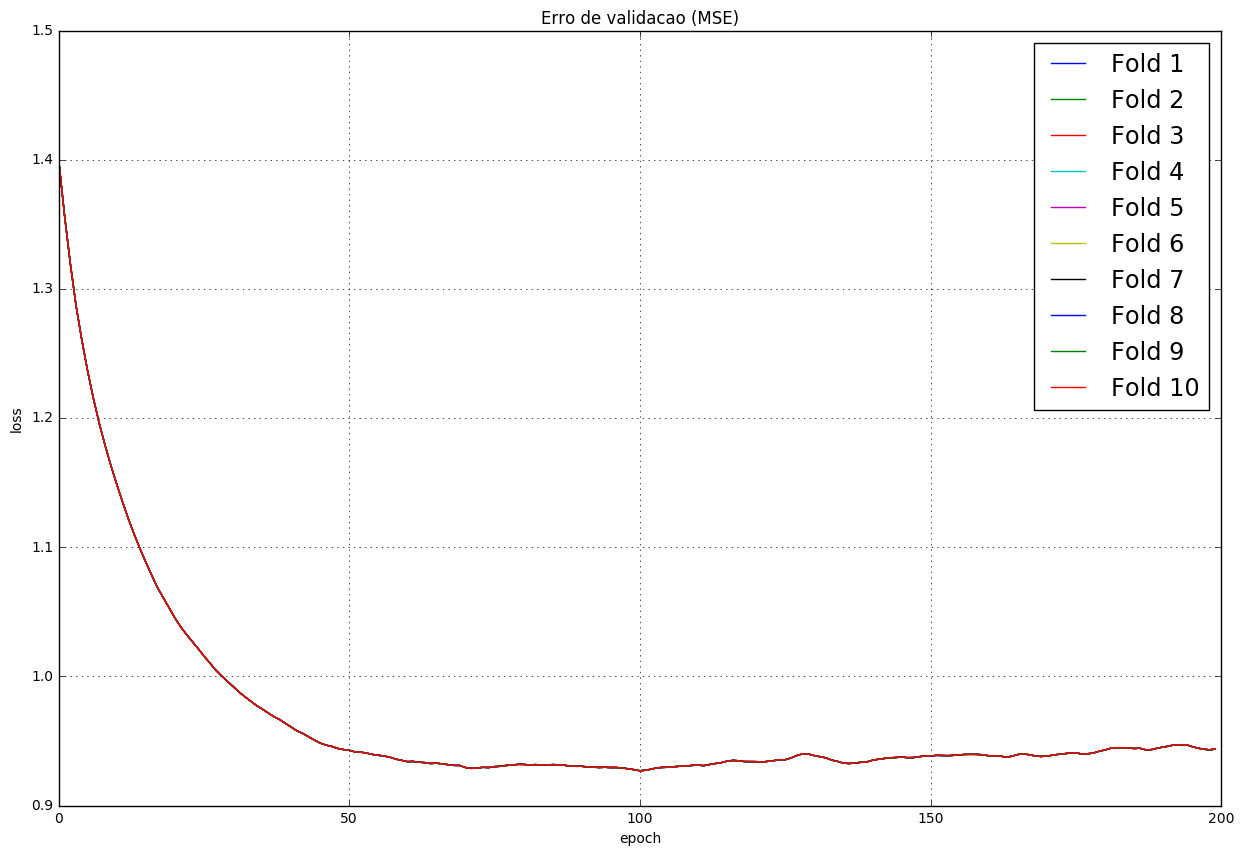

In [418]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(history.history['val_loss'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('Erro de validacao (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

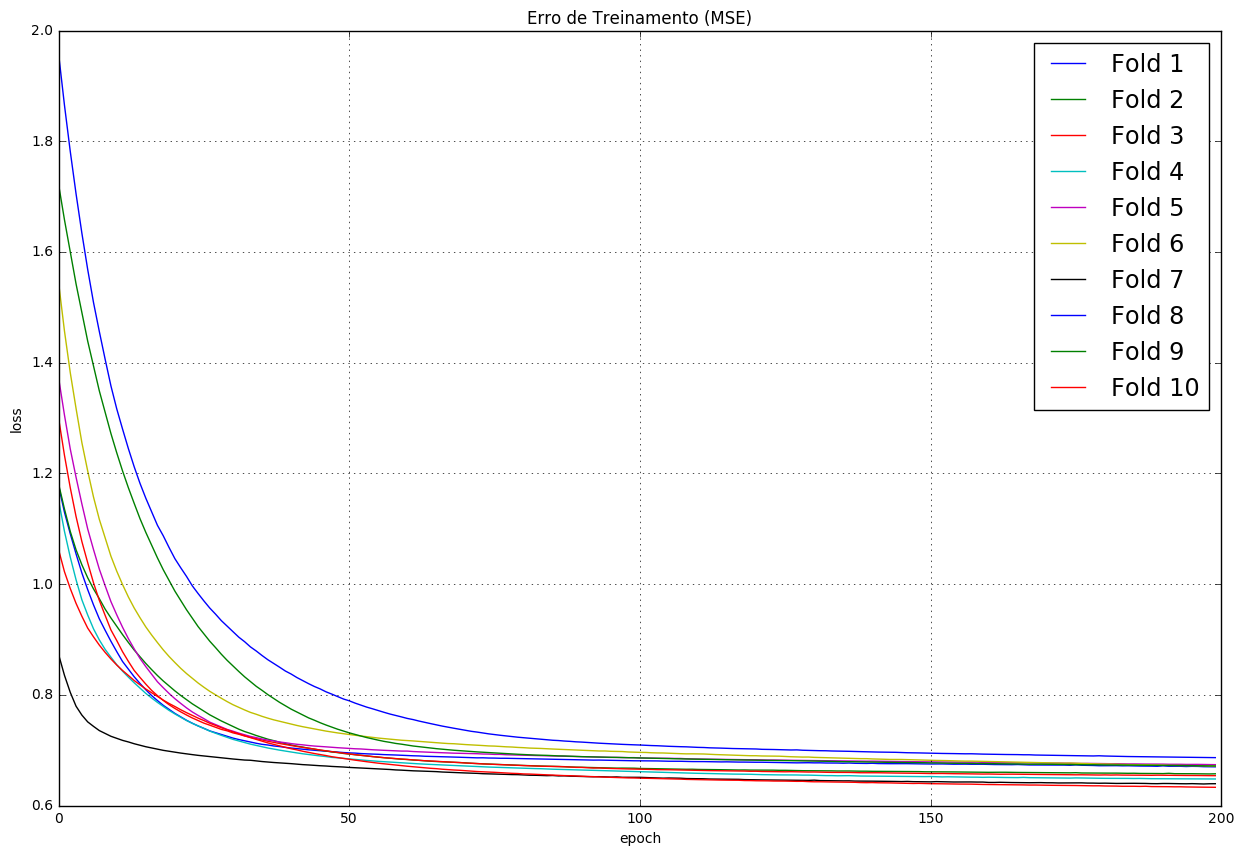

In [420]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(trn_desc[i].history['loss'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('Erro de Treinamento (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

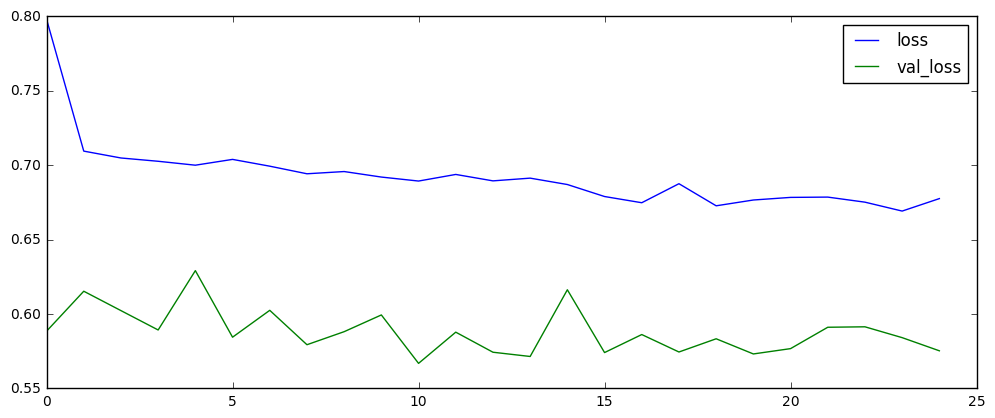

In [81]:
plt.plot(trn_desc[6].history['loss'])
plt.plot(trn_desc[4].history['val_loss'])

plt.legend(['loss', 'val_loss'])
plt.show()

In [270]:
trainsore = model.evaluate(x, y, verbose=0)
testScore = model.evaluate(testx, testy, verbose=0)
trainsore.append("Train")
testScore.append("Teste")
print(trainsore)
print(testScore)
#outdir = "C:/Users/C00310965/Desktop/caloba/output/"
#import csv
#with open(outdir+'test_error.csv','ab') as f:
#    writer=csv.writer(f)
#    writer.writerow(trainsore)
#    writer.writerow(testScore)
#['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

[0.66722826162974036, 0.66722826162974036, 0.63267581450344701, 532855.03830252425, 'Train']
[0.72655633779672479, 0.72655633779672479, 0.67364790171561162, 153.38824860160872, 'Teste']


[0.56344804823872896,
 0.56344804823872896,
 0.5776264300713172,
 224436.60638520826,
 '1']

In [254]:

train_values.mean()

1.3895881403391791e-17

[0.77346831700933261, 0.77346831700933261, 0.66760026376078452, 171.52780013197051]


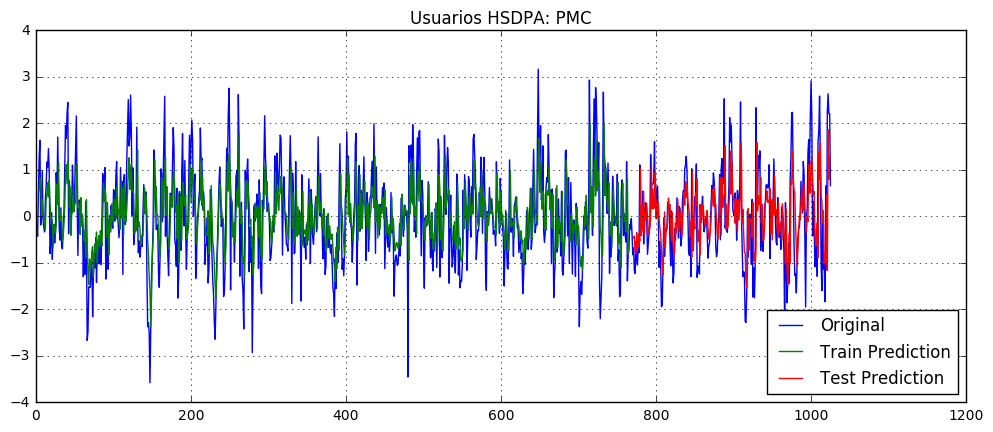

In [421]:
dataset = np.concatenate((train_values, test_values), axis=0)
#frames = [train_set, test_set]
#result = pd.concat(frames)
#dataset = result.ResidualSeries.values
dataset = dataset.astype('float32')
dataset = numpy.expand_dims(dataset, axis=1)  
testScore = model.evaluate(testx, testy, verbose=0)
print(testScore)

trainPredict = model.predict(x)
testPredict = model.predict(testx)

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(dataset,label='Original')
plt.plot(trainPredictPlot,label='Train Prediction')
plt.plot(testPredictPlot,label = 'Test Prediction')
plt.legend(loc='best')
plt.title('Usuarios HSDPA: PMC')
plt.grid()
plt.show()
#plt.plot(history.history['loss'])
#plt.show()

In [191]:
frames = [train_set, test_set]
result = pd.concat(frames)
dataset = result.cell_downlink_avg_thp.values
dataset = dataset.astype('float32')
dataset = numpy.expand_dims(dataset, axis=1)  

#scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.674682)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# reshape dataset
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

start_time = time.time()

# Function to create model, required for KerasClassifier
def create_model():
    # create model Multilayer Perceptron model
    model = Sequential()
    model.add(Dense(4, input_dim=look_back, activation='tanh'))
    model.add(Dense(1,activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
    return model

history = model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)
# Estimate model performance

testScore = model.evaluate(testX, testY, verbose=0)
print(testScore)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

####time taken
timestamp = (time.time() - start_time)
print("time: "+str(timestamp))
# plot baseline and predictions
plt.plot(dataset,label='Original')
plt.plot(trainPredictPlot,label='Train Prediction')
plt.plot(testPredictPlot,label = 'Test Prediction')
plt.legend(loc='best')
plt.title('Throughput HSDPA: Multilayer Perceptron')
plt.show()
plt.plot(history.history['loss'])
plt.show()

(3805, 1836)


Exception: Error when checking model input: expected dense_input_11 to have 2 dimensions, but got array with shape (3800L, 4L, 1L)

In [178]:
print(predictedTest.shape)
print(test_set['SeasonalSeries'].values[8:-1, numpy.newaxis].shape)

print(test_set.shape)

(334L, 1L)
(334L, 1L)
(343, 4)


NameError: name 'loop_back' is not defined

(1.0, -1.4241928012684224e-17)
((343L,), (343L,))
((334L, 1L), (334L, 1L))


In [182]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = numpy.array(y_true), numpy.array(y_pred)
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100
print(mean_absolute_percentage_error(test_set['users'][5:-2].values, ploting))

11.1572394648


(6.0304092984890865, 0.021149258314441446)
((259L,), (259L,))
((254L, 1L), (254L, 1L))


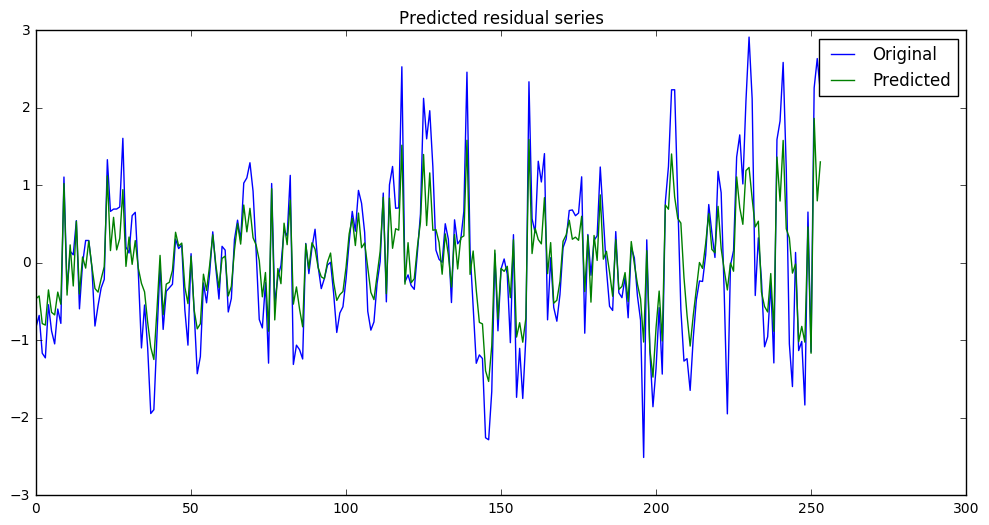

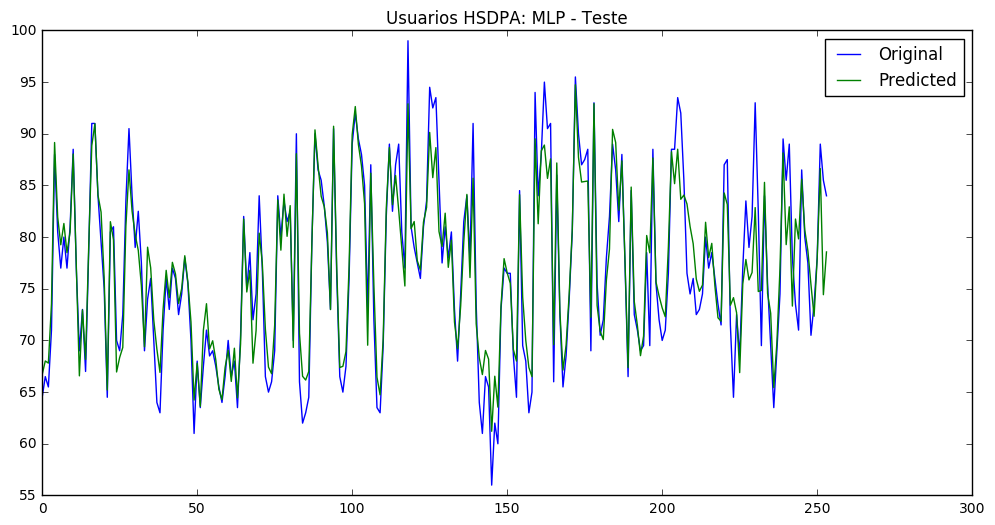

In [422]:
predictedTest = model.predict(testx)

ploting_test = predictedTest*test_std + test_mean 
ploting_test += test_set['SeasonalSeries'].values[3:-2, numpy.newaxis] +test_set['TrendSeries'].values[3:-2, numpy.newaxis]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting_test.shape)
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(test_set['ResidualSeries'][3:-2].values)
plt.plot(predictedTest)
plt.legend(['Original', 'Predicted'])
plt.show()

plt.figure(figsize = (12,6))
plt.title('Usuarios HSDPA: MLP - Teste')
plt.plot(test_set['users'][3:-2].values)
plt.plot(ploting_test)
plt.legend(['Original', 'Predicted'])
#plt.text('MSE %.3f'%)
plt.show()

(0.9999999999999999, 2.6814708645607594e-17)
((767L,), (767L,))
((762L, 1L), (762L, 1L))


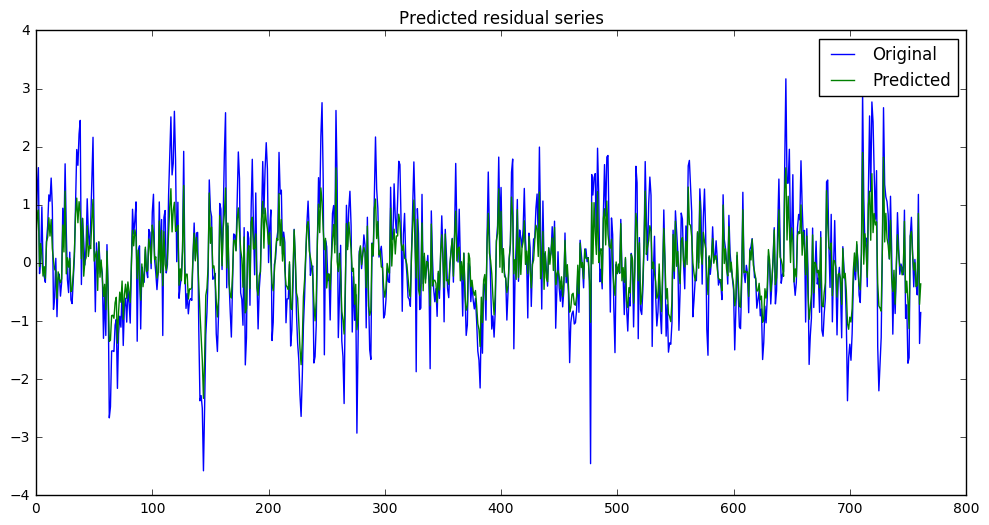

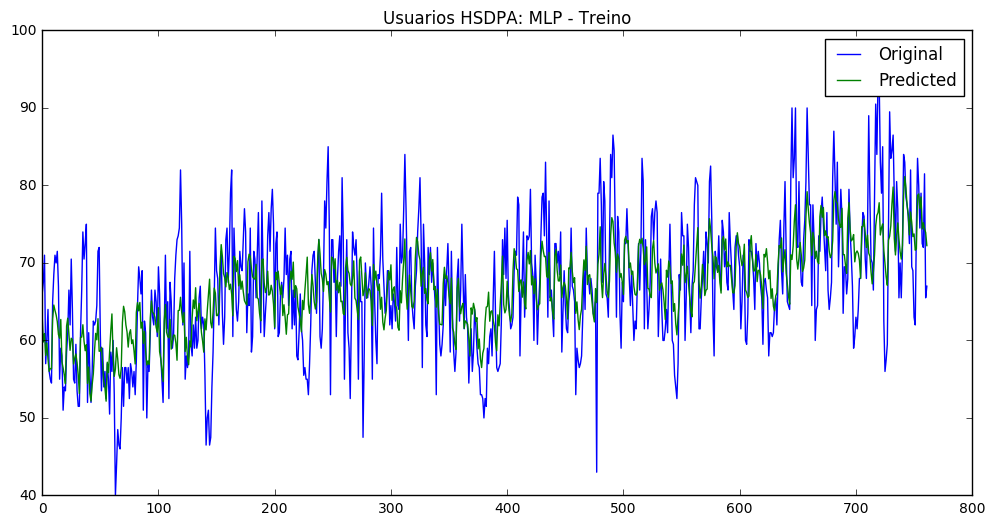

In [362]:
predictedTrain = model.predict(x)

ploting_train = predictedTrain*train_std + train_mean 
ploting_train += train_set['SeasonalSeries'].values[3:-2, numpy.newaxis] +train_set['TrendSeries'].values[3:-2, numpy.newaxis]
print(train_std, train_mean)
print(train_set['SeasonalSeries'].values.shape, train_set['TrendSeries'].values.shape)
print(predictedTrain.shape, ploting_train.shape)

plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(train_set['ResidualSeries'][3:-2].values)
plt.plot(predictedTrain)
plt.legend(['Original', 'Predicted'])
plt.show()

plt.figure(figsize = (12,6))
plt.title('Usuarios HSDPA: MLP - Treino')
plt.plot(train_set['users'][3:-2].values)
plt.plot(ploting_train)
plt.legend(['Original', 'Predicted'])
#plt.text('MSE %.3f'%)
plt.show()


In [208]:
print(mean_absolute_percentage_error(test_set['users'][5:-2].values, ploting))

In [231]:
import math
def mse(y,yhat,n):
    tmp = 0.0

    for i in range(0,n):
        tmp += ((y[i]-yhat[i])**2)

    return tmp/n

def rmse(y,yhat,n):

    return math.sqrt(mse(y,yhat,n))

def mape(y,yhat,n):
    tmp = 0.0

    for i in range(0,n):
        tmp += math.fabs(y[i]-yhat[i])/y[i]

    return (tmp/n)

def erro_prev(y,yhat,n):
    tmp = []

    for i in range(0,n):
        tmp.append((y[i]-yhat[i]))

    return tmp

def erro_rms(y,yhat,n):
    tmp = []

    for i in range(0,n):
        s=0
        for k in range(i+1):
            s = s+(y[k]-yhat[k])**2
        s=s/(i+1)
        tmp.append(math.sqrt(s))

    return tmp

In [149]:
for i in range(0,10):
    s = 0
    for k in range(i+1):
        s +=1
    print(s)

1
2
3
4
5
6
7
8
9
10


In [222]:
plot_train = []
for a in range(ploting_train.shape[0]):
    plot_train.append(ploting_train[a][0])

plot_test = []
for a in range(ploting_test.shape[0]):
    plot_test.append(ploting_test[a][0])

In [231]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTest, testy))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting_test, test_set['users'][7:-2].values))

Mean absolute error for residual series: 0.6558
Mean absolute error for complete series: 4.8515


In [232]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTrain,y))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting_train, train_set['users'][7:-2].values))

Mean absolute error for residual series: 0.6207
Mean absolute error for complete series: 4.7907


In [97]:
from sklearn.metrics import mean_absolute_error
import math
result_mae  = mean_absolute_error(test_set['users'][3:-2].values,ploting_test)
result_mse = mse(test_set['users'][3:-2].values,ploting_test,test_set['users'][3:-2].values.shape[0])
result_rmse = rmse(test_set['users'][3:-2].values,ploting_test,test_set['users'][3:-2].values.shape[0])
result_mape = mape(test_set['users'][3:-2].values,ploting_test,test_set['users'][3:-2].values.shape[0])
print(result_mse,result_rmse,result_mae,result_mape)

(array([ 12.19761658], dtype=float32), 3.4925086366605362, 2.550315281343178, 0.033535246475548126)


In [98]:
from sklearn.metrics import mean_absolute_error
import math
result_mae  = mean_absolute_error(train_set['users'][3:-2].values,ploting_train)
result_mse = mse(train_set['users'][3:-2].values,ploting_train,train_set['users'][3:-2].values.shape[0])
result_rmse = rmse(train_set['users'][3:-2].values,ploting_train,train_set['users'][3:-2].values.shape[0])
result_mape = mape(train_set['users'][3:-2].values,ploting_train,train_set['users'][3:-2].values.shape[0])
print(result_mse,result_rmse,result_mae,result_mape)

(array([ 11.96186256], dtype=float32), 3.458592569830525, 2.6002476559536349, 0.039542151885612969)


In [99]:
result_erro = numpy.array(erro_prev(train_set['users'][3:-2].values,ploting_train,train_set['users'][3:-2].values.shape[0]))

In [370]:
result_erro_rms = numpy.array(erro_rms(test_set['ResidualSeries'][3:-2].values,predictedTest*test_std + test_mean,test_set['users'][3:-2].values.shape[0]))

In [ ]:
test_set['ResidualSeries'][3:-2].values
predictedTest*test_std + test_mean

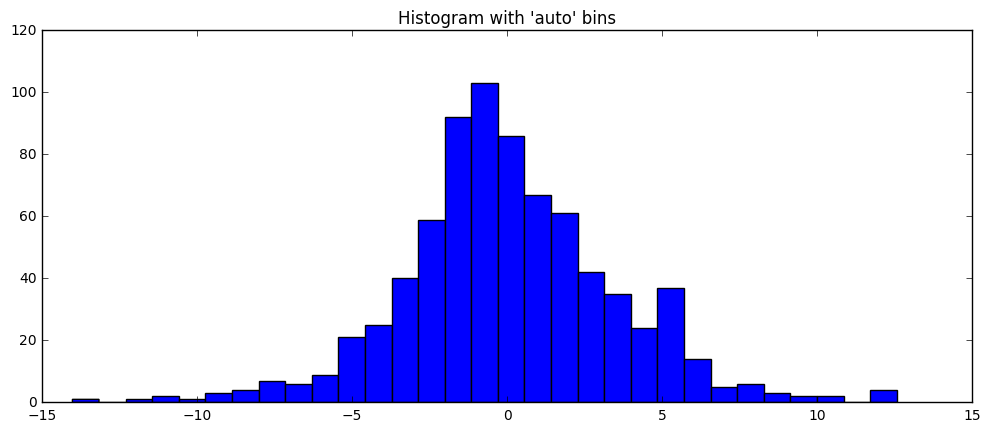

In [101]:
#numpy.histogram(result_erro,10).plot(kind='kde')
plt.hist(result_erro, bins='auto') 
plt.title("Histogram with 'auto' bins")

In [102]:
result_erro = numpy.array(erro_prev(testy,predictedTest,len(testy)))

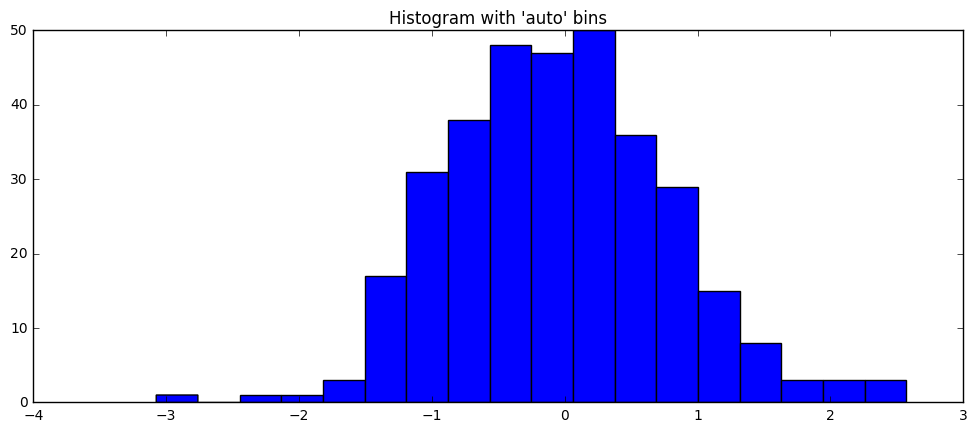

In [268]:
plt.hist(result_erro, bins='auto') 
plt.title("Histogram with 'auto' bins")

In [271]:
numpy.histogram(result_erro, bins='auto')[0]

array([ 1,  0,  1,  1,  3, 17, 31, 38, 48, 47, 50, 36, 29, 15,  8,  3,  3,
        3], dtype=int64)

In [342]:
3*math.sqrt(0.7256)

2.5554647326856226

In [159]:
len(test_series)

338

In [156]:
test_series = test_set['ResidualSeries'][3:-2].values

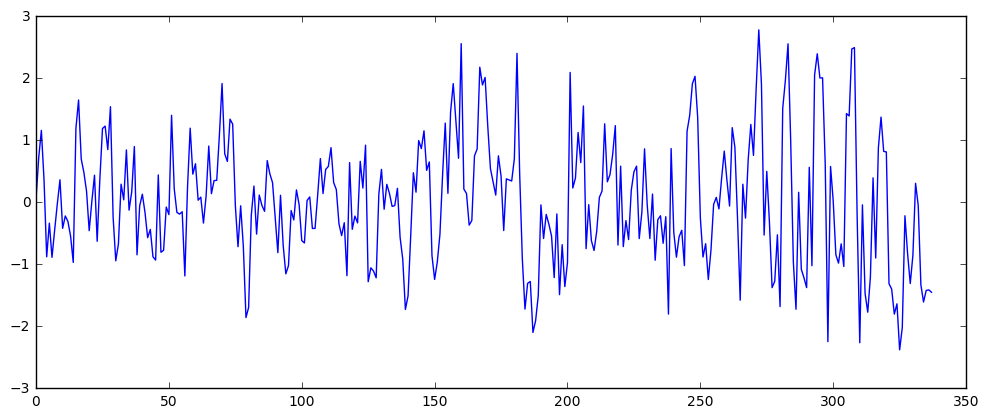

In [111]:
import numpy as np
import seaborn
import scipy.stats as st
outdir = "C:/Users/C00310965/Desktop/caloba/output/aaa"
#graph_fittedData(numpy.histogram(result_erro, bins='auto')[0],outdir,0)
graph_fittedData(result_erro,outdir,0)



In [ ]:
ax = sns.tsplot(time="timepoint", value="BOLD signal",unit="subject", condition="ROI",data=gammas)

In [93]:
ts = pd.Series(data=predictedTrain.squeeze())

In [110]:
ts_testmais

NameError: name 'ts_testmais' is not defined

In [109]:
ts['ts_mais'] = 

0      0.395638
1      0.721568
2      0.902233
3     -0.107344
4      0.217229
5      0.212800
6     -0.114580
7     -0.024762
8     -0.226689
9      0.254979
10     0.394376
11     0.755374
12     0.525822
13     0.850564
14     0.334775
15    -0.051589
16    -0.134824
17    -0.129551
18    -0.688274
19    -0.042272
20    -0.236462
21    -0.350914
22    -0.200673
23     0.595674
24     0.308085
25     1.106801
26    -0.055314
27     0.078804
28    -0.133086
29     0.040797
         ...   
732    0.258598
733    0.342239
734    0.070348
735    0.667154
736   -0.160739
737   -0.426898
738   -0.142979
739   -0.685042
740    0.115402
741    0.509313
742    0.242462
743   -0.034207
744   -0.037422
745   -0.120505
746   -0.127135
747    0.614856
748   -0.640841
749   -0.285533
750   -0.774029
751   -1.039864
752    0.248933
753    0.477212
754    0.309319
755   -0.130197
756   -0.002116
757   -0.312696
758   -0.328832
759    0.746691
760   -0.911762
761   -0.274740
dtype: float32

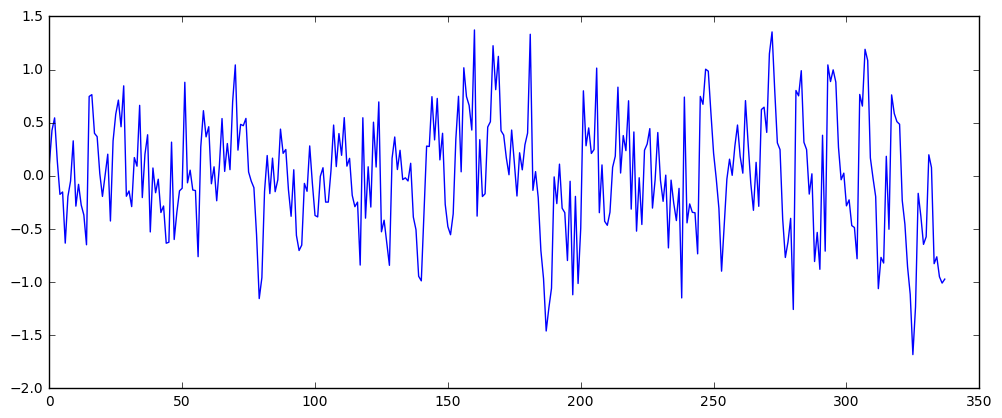

In [162]:
plt.plot(predictedTest)

In [238]:
ts_test = pd.Series(data=predictedTest.squeeze())

In [365]:
residual_test = test_set['ResidualSeries'][3:-2].values
ts_test = predictedTest*test_std + test_mean

In [384]:
ts_test = pd.Series(data=ts_test.squeeze())


C:\Anaconda2\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


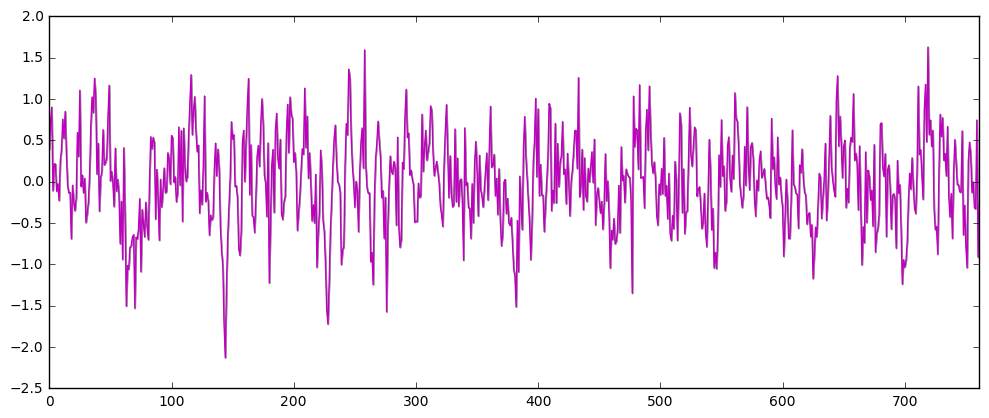

In [95]:
import seaborn as sns
ax = sns.tsplot(data=ts, ci=[68, 95], color="m")

In [112]:
2*math.sqrt(0.7654)

1.7497428382479523

In [382]:
ts_test

array([[  8.57242644e-02],
       [  5.11364520e-01],
       [  5.55997133e-01],
       [  1.01417050e-01],
       [ -1.80093706e-01],
       [ -1.44798756e-01],
       [ -6.14436805e-01],
       [ -3.22505206e-01],
       [  3.60611789e-02],
       [  4.01337266e-01],
       [ -2.64857113e-01],
       [ -1.14752889e-01],
       [ -3.15886140e-01],
       [ -4.04708922e-01],
       [ -6.80916309e-01],
       [  9.84062493e-01],
       [  7.76450276e-01],
       [  4.09157693e-01],
       [  5.10020435e-01],
       [  2.31420528e-03],
       [ -1.26560122e-01],
       [  4.57494985e-03],
       [  1.68133616e-01],
       [ -3.64352822e-01],
       [  3.01938891e-01],
       [  5.25025070e-01],
       [  6.94122136e-01],
       [  4.19371009e-01],
       [  7.93140590e-01],
       [ -2.58726001e-01],
       [ -1.46640345e-01],
       [ -2.77384877e-01],
       [  2.72562087e-01],
       [  8.37320089e-02],
       [  7.30649412e-01],
       [ -3.45781267e-01],
       [  2.06608191e-01],
 

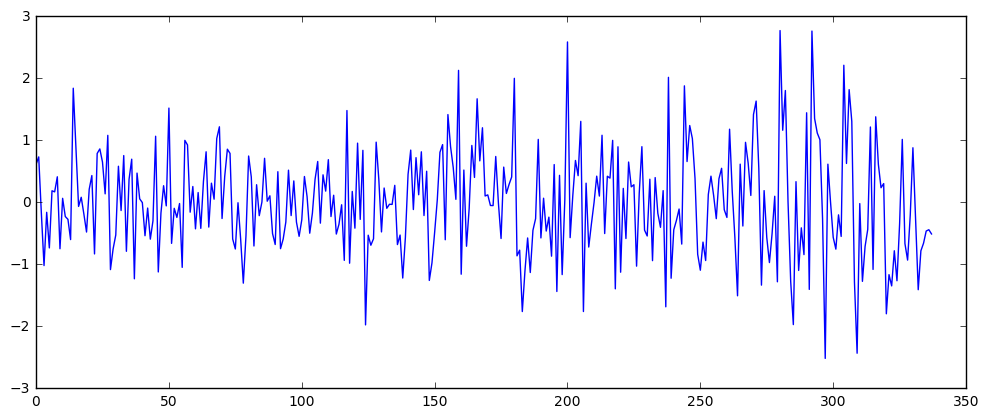

In [144]:
plt.plot(result_erro)#,yerr=1.749)

In [201]:
aaaa = np.arange(0,338,1)
print(aaaa)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [401]:
ts_test[304]

-0.73298168

In [402]:
testoutlier[304] = 3.2


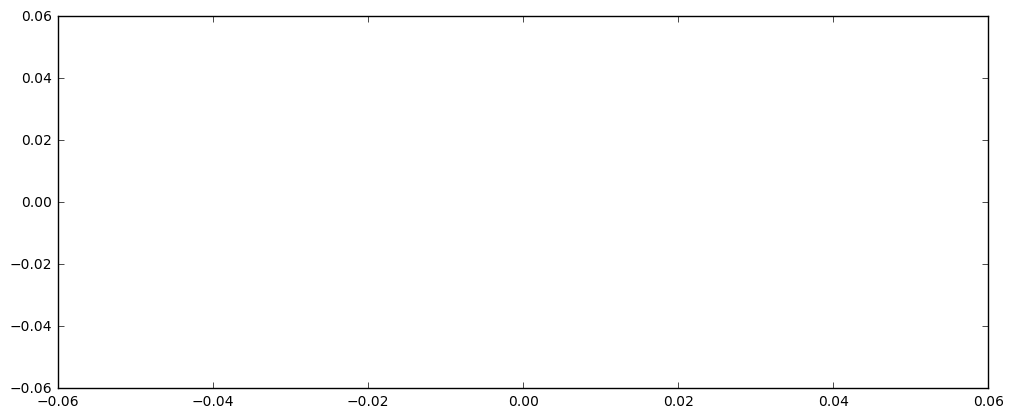

In [438]:
#plt.plot(predictedTest*test_std + test_mean)
#plt.plot(test_set['ResidualSeries'][3:-2].values)

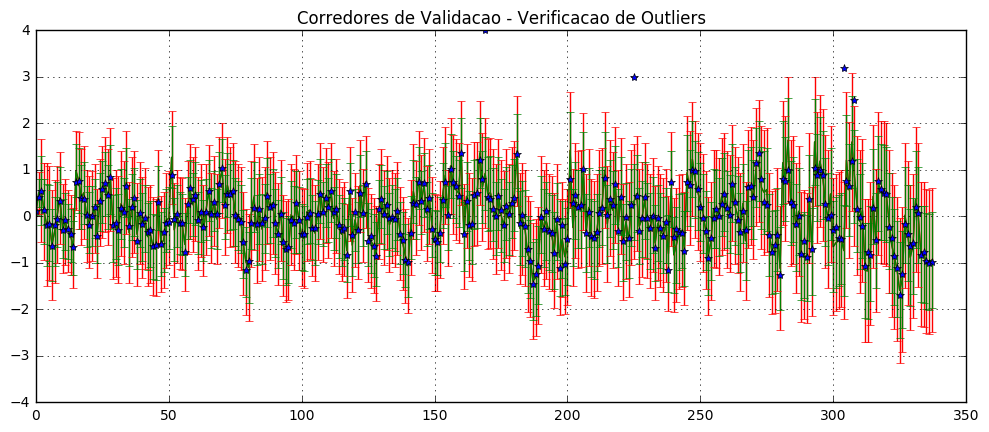

In [405]:
import seaborn as sns
import scipy 
from numpy import nanmean
#ts_test.dropna(axis = 0, how = 'any', inplace = True)
#sns.tsplot(ts_test, ci=[68, 95],err_style='ci_band',estimator=nanmean)
plt.grid()
#plt.show()
ts_testmenos = ts_test-3*np.array(result_erro_rms)
ts_testmais = ts_test+3*np.array(result_erro_rms)

#sns.tsplot(test_set['ResidualSeries'][3:-2].values,interpolate=False,ci='sd',color='indianred',)
plt.errorbar(aaaa,ts_test, 3*np.array(result_erro_rms),color='r')
plt.errorbar(aaaa,ts_test, 2*np.array(result_erro_rms),color='g')
plt.plot(testoutlier ,linestyle='None',marker='*',label='actual')
plt.title('Corredores de Validacao - Verificacao de Outliers')
#plt.plot(residual_test,color='g')

#plt.plot(ts_testmenos,'-',color='b')
#plt.plot(ts_testmais,'-',color='b')
#result_erro_rms
#residual_test

In [380]:

np.array(result_erro_rms

SyntaxError: invalid syntax (<ipython-input-380-eca146a3f9e6>, line 2)

In [374]:
result_erro_rms2 = []
for i in range(len(result_erro_rms)):
    if(i<30):
        result_erro_rms2.append(result_erro_rms[i]/3)
    else:
        result_erro_rms2.append(result_erro_rms[i])

In [192]:
len(3*np.array(result_erro_rms2))

338

In [173]:
import gtk
from matplotlib.backends.backend_gtkagg import FigureCanvasGTKAgg as FigureCanvas
from matplotlib.backends.backend_gtkagg import NavigationToolbar2GTKAgg as NavigationToolbar

from matplotlib.figure import Figure
win = gtk.Window()
win.connect("destroy", lambda x: gtk.main_quit())
win.set_default_size(400,300)
win.set_title("Embedding in GTK")

vbox = gtk.VBox()
win.add(vbox)

ImportError: No module named gtk

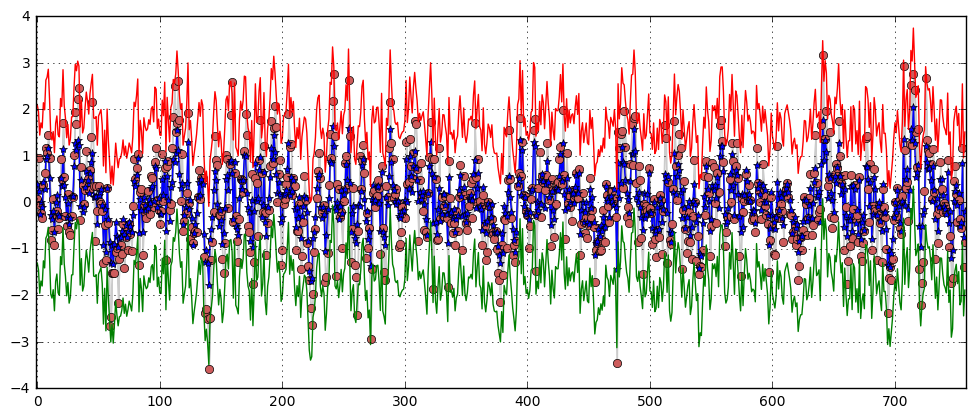

In [348]:
import seaborn as sns
import scipy 
from numpy import nanmean
ts.dropna(axis = 0, how = 'any', inplace = True)
sns.tsplot(ts, ci=[68, 95],err_style='ci_band',estimator=nanmean)
plt.grid()
#plt.show()
tsmenos = ts-1.7
tsmais = ts+1.7

sns.tsplot(train_set['ResidualSeries'][7:-2].values,interpolate=False,ci='sd',color='indianred',)
ax.errorbar(ts, train_set['ResidualSeries'][7:-2].values)
plt.plot(ts ,linestyle='None',marker='*',label='actual')
plt.plot(tsmenos)
plt.plot(tsmais)

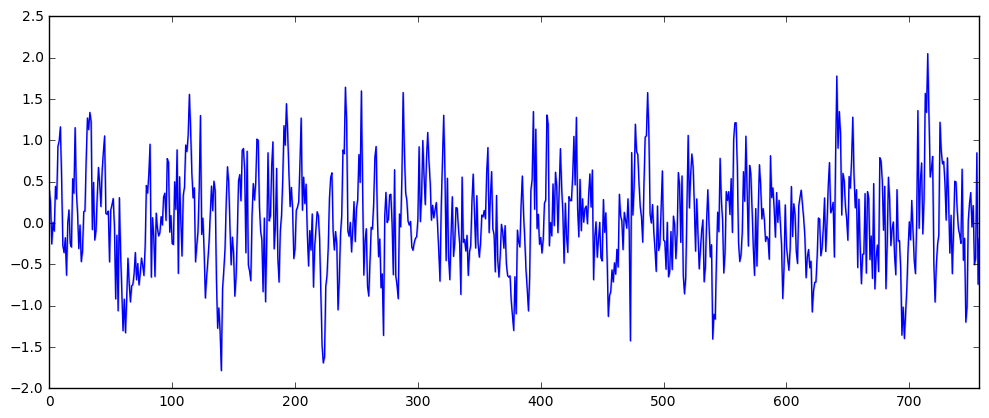

In [334]:
ax = sns.tsplot(data=ts, estimator=np.median)

In [108]:
def best_fit_distribution(data, bins=200, ax=None):
    import warnings
    import numpy as np
    import pandas as pd
    import scipy.stats as st
    import statsmodels as sm
    import matplotlib
    import matplotlib.pyplot as plt

    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins = bins, normed = True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [        
    #    st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
    #    st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
    #    st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
    #    st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
    #    st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
    #    st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
    #    st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
    #    st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    #    st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
    #    st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    #]

    DISTRIBUTIONS = [
        st.arcsine, st.beta, st.cauchy, st.chi, st.chi2, st.dweibull, st.erlang, st.fisk, st.gamma, st.laplace,
        st.logistic, st.loggamma, st.loglaplace, st.maxwell, st.norm, st.lognorm, st.rayleigh, st.triang, st.uniform
    ]
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_pdf_statistics = st.norm.stats(loc = 0, scale = 1, moments = 'mvsk')
    best_p = 0
    best_chi2_stat = np.inf
    best_log_likelihood = -np.inf
    
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                pdf_statistics = distribution.stats(loc=loc, scale=scale, moments = 'mvsk', *arg)

                deltaDof = len(params)
    
                        
    
                chi_squared_stat = (((y - pdf)**2)/pdf).sum()

                p_value = 1 - st.chi2.cdf(x = chi_squared_stat, df = len(y) - 1 - deltaDof)
               
                log_likelihood = distribution.logpdf(x, loc = loc, scale = scale, *arg).sum()
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax = ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                #if p_value > best_p:
                #if np.abs(1 - normalized_chi2_stat) < np.abs(1-best_normalized_chi2):
                if best_chi2_stat > chi_squared_stat > 0:
                #if best_log_likelihood < log_likelihood:
                    best_distribution = distribution
                    best_params = params
                    #best_sse = sse
                    best_p = p_value
                    best_pdf_statistics = pdf_statistics
                    #best_normalized_chi2 = normalized_chi2_stat
                    best_chi2_stat = chi_squared_stat
                    best_log_likelihood = log_likelihood
                    
        except Exception:
            pass

    return (best_distribution.name, best_params, best_chi2_stat, best_p, best_pdf_statistics, best_log_likelihood)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    #pdf = pd.Series(y, x)

    #return pdf
    return y

def graph_fittedData(data_to_be_fitted,outdir,i):
    from scipy.stats import laplace, chisquare, norm
    #plt.clf()
    fig, ax = plt.subplots(1,figsize=(15,10))
    lnspace = np.linspace(np.amin(data_to_be_fitted), np.amax(data_to_be_fitted), len(data_to_be_fitted))

    plt.hist(data_to_be_fitted, bins = 'fd', normed=True)

    import seaborn as sb
    import scipy.stats as st
    best_fit_name, best_fit_paramms, chi2_stat, p_value, pdf_stats, log_likelihood  = best_fit_distribution(data_to_be_fitted, bins = 'fd')
    best_dist = getattr(st, best_fit_name)

    arg = best_fit_paramms[:-2]
    pdf = best_dist.pdf(lnspace, loc = best_fit_paramms[-2], scale = best_fit_paramms[-1], *arg)

    mu = pdf_stats[0]
    var = pdf_stats[1]
    skew = pdf_stats[2]
    kurt = pdf_stats[3]

    plt.plot(lnspace, pdf, 'c')
    plt.title(best_fit_name + ' PDF')
    textstring = '$\mu = %.4f$\n$\delta ^2 = %.4f$\n$skew = %.4f$\n$kurt = %.4f$\n$\chi ^2 = %.4f$\n$p_{value} = %.4f$\n$log likelihood = %.4f$'%(mu, var, skew, kurt, chi2_stat, p_value, log_likelihood)


    plt.text(4.2, 0.10, textstring,ha='left',wrap=True)
    
    #ax = plt.gca()
    #ax.annotate(textstring, xy=(4.2, 0.10))
    #ax.set_xlim(-.4,.4)
    #ax.set_xlim(-.4,.4)
    #fig = plt.figure()
    #plt.show()
    fig.savefig(outdir+'tempt.png',bbox_inches="tight")
    plt.clf()

    return None